In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os
import pickle
import spyglass as nd
import pandas as pd
import statsmodels.api as sm
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import multiprocessing

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection


# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.Analysis_SGU import (TrialChoice,
                                            TrialChoiceRemoteReplay,
                                            TrialChoiceReplay,
                                            RippleTimes,
                                            Decode,
                                            TrialChoiceReplayTransition,
                                            get_linearization_map,
                                            find_ripple_times,classify_ripples,classify_ripple_content)
from spyglass.shijiegu.PastFuture_Replay import (replay_in_categories,find_distinct_subset,proportion,
                                                 unravel_replay,count_replay_by_category,category_day)

[2024-10-27 11:14:42,163][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
27-Oct-24 11:14:42 Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2024-10-27 11:14:42,258][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306
27-Oct-24 11:14:42 Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [4]:
pd.set_option('display.max_rows', None)

In [22]:
def find_behavior_transitions(index,outers): #P(xi|xj)
    T=np.zeros((4,4))
    for t in range(len(outers)-2):
        if (index[t+1]-index[t])==1:
            T[int(outers[t])-1,int(outers[t+1])-1] += 1 # minus 1 due to python indexing
    #for ti in range(4):
    #    T[ti]=T[ti]/np.sum(T[ti])
    return T

def matrix_correlation(M1,M2):
    return np.sum(np.multiply(M1,M2))/(np.linalg.norm(M1,ord='fro')*np.linalg.norm(M2,ord='fro'))

def normalize_offdiag(T_):
    T=T_.copy()
    np.fill_diagonal(T, 0)
    for ti in range(4):
        if np.sum(T[ti])!=0:
            T[ti]=T[ti]/np.sum(T[ti])
    return T

def normalize(T_):
    T=T_.copy()
    for ti in range(4):
        if np.sum(T[ti])!=0:
            T[ti]=T[ti]/np.sum(T[ti])
    return T

def remove_diag(T_):
    T=T_.copy()
    np.fill_diagonal(T, 0)
    return T

In [23]:
def find_transitions_from_pairs(all_pairs):
    T=np.zeros((4,4))
    for p in range(all_pairs.shape[0]):
        T[all_pairs[p][0],all_pairs[p][1]]+=1
    return T

def find_transitions_from_pairs_offdiagonal(P_behavior_count,all_pairs):
    T=np.zeros((4,4))
    for p in range(all_pairs.shape[0]):
        if all_pairs[p][0]!=all_pairs[p][1]:
            T[all_pairs[p][0],all_pairs[p][1]]+=1
        if np.sum(T)==np.sum(P_behavior_count):
            break
    return T

def bootstrap_transition(P,offdiagonal_only=True):
    '''
    Get all the pairs, and independently sample each tuple.
    '''
    all_pairs=[]
    for i in range(4):
        all_pairs_i=[]
        for j in range(4):
            for p in range(int(P[i,j])):
                all_pairs.append([i,j])
    all_pairs=np.array(all_pairs)

    all_pairs_boot=np.zeros((2*len(all_pairs[:,1]),2)).astype('int') 
     #sample more than what is needed, because some are sampled [a,a] transitions, a=1:4, which are excluded later.
    all_pairs_boot[:,0]=np.random.choice(all_pairs[:,0],len(all_pairs_boot[:,0]))
    all_pairs_boot[:,1]=np.random.choice(all_pairs[:,1],len(all_pairs_boot[:,1]))
    
    if offdiagonal_only:
        bootstrapped_P=find_transitions_from_pairs_offdiagonal(P,all_pairs_boot)
    else:
        bootstrapped_P=find_transitions_from_pairs(P,all_pairs_boot)
    return bootstrapped_P

In [7]:
seq1=[2,4,1,3];
seq2=[3,4,2,1];
seq3=[1,2,3,4];

rev1=[2,3,1,4];
rev2=[2,4,3,1];
rev3=[1,4,3,2];

seqs=np.vstack((seq1,seq2,seq3,rev1,rev2,rev3))
orders=['Seq1','Seq2','Seq3','Rev1','Rev2','Rev3']

P_task=np.zeros((4,4,6))
for s in range(6):
    for a in range(4):
        P_task[seqs[s,a%4]-1,seqs[s,(a+1)%4]-1,s]=1

In [144]:
'''
datafolder='/stelmo/shijie/recording_pilot/molly/plot/'
files=['molly20220415_.nwb','molly20220416_.nwb',
 'molly20220417_.nwb','molly20220418_.nwb',
 'molly20220419_.nwb','molly20220420_.nwb']
days=[1,2,3,4,5,6]
'''

datafolder='/cumulus/shijie/recording_pilot/eliot/plot/'
'''
files=['eliot20221016_.nwb','eliot20221017_.nwb',
       'eliot20221018_.nwb','eliot20221019_.nwb',
       'eliot20221020_.nwb','eliot20221021_.nwb',
       'eliot20221022_.nwb']
'''
animal = 'Eliot'
files=['eliot20221019_.nwb','eliot20221020_.nwb','eliot20221021_.nwb',
       'eliot20221022_.nwb','eliot20221023_.nwb','eliot20221024_.nwb','eliot20221025_.nwb','eliot20221026_.nwb']
days=[6,7,8,9,10,11,12,13]
encoding_set = '2Dheadspeed_above_4_andlowmua'
classifier_param_name = 'default_decoding_gpu_4armMaze'


datafolder='/cumulus/shijie/recording_pilot/lewis/plot/'
animal = 'Lewis'
files=['lewis20240105_.nwb','lewis20240106_.nwb','lewis20240107_.nwb','lewis20240108_.nwb','lewis20240109_.nwb',
       'lewis20240110_.nwb','lewis20240113_.nwb','lewis20240114_.nwb','lewis20240115_.nwb',
       'lewis20240116_.nwb','lewis20240117_.nwb','lewis20240118_.nwb','lewis20240119_.nwb','lewis20240120_.nwb']
days=[12,13,14,15,16,
      17,18,19,1,
      2,3,4,5,6]

encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'default_decoding_gpu_4armMaze'

[2024-11-06 14:32:00,459][WARNING]: MySQL server has gone away. Reconnecting to the server.
06-Nov-24 14:32:00 MySQL server has gone away. Reconnecting to the server.


In [145]:
def day_probabilities(nwb_copy_file_name,encoding_set,classifier_param_name, bootstrap=False):

    '''choose a day'''
    #nwb_copy_file_name='molly20220417_.nwb'
    all_epochs= np.unique((TrialChoiceReplayTransition() & {'nwb_file_name':nwb_copy_file_name}).fetch("interval_list_name"))

    P_behavior_count=np.zeros((4,4))
    P_replay_count=np.zeros((4,4))

    '''choose an epoch'''
    for epoch_name in all_epochs:
        '''get the behavior + ripple/replay + parsed replay data on this day and this epoch'''
        T=pd.DataFrame((TrialChoiceReplayTransition() & {
            'nwb_file_name':nwb_copy_file_name,
            'interval_list_name':epoch_name,
            'classifier_param_name':classifier_param_name,
            'encoding_set':encoding_set}).fetch1('choice_reward_replay_transition'))
        
        # find trials without position decoding, which are also the one I did not parse ripple time
        # Do this only for behavior, since replay depends on ripple, and is already skipped for these trial accordingly
        #ripple_H=np.array(T.ripple_H)
        ripple_H=np.array(T.replay_H)
        have_LED_trackingindex=[len(ripple_H[i])!=0 for i in range(len(ripple_H))]
        
        P_behavior_count+=find_behavior_transitions(np.array(T.index),
                                                        np.array(T.OuterWellIndex))
        
        '''
        P_behavior_count+=find_behavior_transitions(np.array(T.index[have_LED_trackingindex]),
                                                        np.array(T.loc[T.index[have_LED_trackingindex],'OuterWellIndex']).astype('int'))
        '''

        P_replay_count+=(TrialChoiceReplayTransition() &
                         {
            'nwb_file_name':nwb_copy_file_name,
            'interval_list_name':epoch_name,
            'classifier_param_name':classifier_param_name,
            'encoding_set':encoding_set}).fetch1('transitions')

    
    if bootstrap:
        P_replay_count=remove_diag(P_replay_count)
        P_replay_count_bootstrap=bootstrap_transition(P_replay_count,
                                                      offdiagonal_only=True)
        P_replay=normalize_offdiag(P_replay_count_bootstrap)
        
        P_behavior_count_bootstrap=bootstrap_transition(P_behavior_count,
                                                      offdiagonal_only=True)
        P_behavior=normalize_offdiag(P_behavior_count_bootstrap)
        
    else:
        P_behavior=normalize_offdiag(P_behavior_count)
        P_replay=normalize_offdiag(P_replay_count)
        P_replay_count=remove_diag(P_replay_count)


    xcorr_behavior_replay=matrix_correlation(P_replay,P_behavior)
    xcorr_behavior_task=[matrix_correlation(P_behavior,P_task[:,:,s]) for s in range(P_task.shape[2])]
    xcorr_replay_task=[matrix_correlation(P_replay,P_task[:,:,s]) for s in range(P_task.shape[2])]
    
    np.fill_diagonal(P_replay, np.nan)
    np.fill_diagonal(P_behavior, np.nan)
    
    return P_behavior_count,P_replay_count,P_replay,P_behavior,xcorr_behavior_replay,xcorr_behavior_task,xcorr_replay_task

### 1. For each day, calculate transition probabilities and their correlations

In [146]:
behavior_replay=[]
behavior_task=[]
replay_task=[]
P_replay=np.zeros((4,4,len(files)))
P_behavior=np.zeros((4,4,len(files)))
P_replay_count=np.zeros(len(files))
P_behavior_count=np.zeros(len(files))

f_ind=0
for f in files:
    (P_behavior_count_,P_replay_count_,P_replay_,P_behavior_,
         behavior_replay_,behavior_task_,replay_task_)=day_probabilities(f,encoding_set = encoding_set,
                                                                         classifier_param_name = classifier_param_name)
    behavior_replay.append(behavior_replay_)
    behavior_task.append(behavior_task_)
    replay_task.append(replay_task_)
    
    P_replay[:,:,f_ind]=P_replay_
    P_behavior[:,:,f_ind]=P_behavior_
    P_replay_count[f_ind]=np.sum(P_replay_count_)
    P_behavior_count[f_ind]=np.sum(P_behavior_count_)
    f_ind+=1
    
replay_task=np.array(replay_task)
behavior_task=np.array(behavior_task)
behavior_replay=np.array(behavior_replay)

In [147]:
'''
exclude the day with too few data (pairwise replay)
'''

enough_ind=np.argwhere(P_replay_count>5).ravel() #for molly: 20

replay_task=replay_task[enough_ind]
behavior_task=behavior_task[enough_ind]
behavior_replay=behavior_replay[enough_ind]

P_replay=P_replay[:,:,enough_ind]
P_behavior=P_behavior[:,:,enough_ind]
P_replay_count=P_replay_count[enough_ind]
P_behavior_count=P_behavior_count[enough_ind]

files=[files[i] for i in enough_ind]
days=[days[i] for i in enough_ind]

In [148]:
P_replay_count

array([23., 28., 26., 21., 19.,  8., 13., 23., 14., 21., 30., 42., 22.,
       48.])

In [149]:
def bootstrap_transition_day(files):
    behavior_replay_b=[]
    replay_task_b=[]
    behavior_task_b=[]
    for f in files:
        _,_1,P_replay_,P_behavior_,behavior_replay_,behavior_task_,replay_task_=day_probabilities(f,
                                                                        encoding_set = encoding_set,
                                                                         classifier_param_name = classifier_param_name,
                                                                        bootstrap=True)
        behavior_replay_b.append(behavior_replay_)
        replay_task_b.append(replay_task_)
        behavior_task_b.append(behavior_task_)

    replay_task_b=np.array(replay_task_b)
    behavior_replay_b=np.array(behavior_replay_b)
    behavior_task_b=np.array(behavior_task_b)
    return (replay_task_b,behavior_replay_b,behavior_task_b)

In [ ]:
B=1000
results = []
for b in range(B):
    print(b)
    results.append(bootstrap_transition_day(files))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [158]:
# only use when B < 100
B=100
with multiprocessing.Pool(2) as p:
    results=p.map(bootstrap_transition_day,
                  [files for s in range(B)])

[2024-11-06 14:38:54,332][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2024-11-06 14:38:54,336][WARNING]: MySQL server has gone away. Reconnecting to the server.
06-Nov-24 14:38:54 MySQL server has gone away. Reconnecting to the server.
06-Nov-24 14:38:54 MySQL server has gone away. Reconnecting to the server.


KeyboardInterrupt: 

In [162]:
behavior_replay_boot=np.zeros((len(files),B))
replay_task_boot=np.zeros((len(files),P_task.shape[2],B))
behavior_task_boot=np.zeros((len(files),P_task.shape[2],B))

for b in range(B):
    replay_task_boot[:,:,b]=results[b][0]
    behavior_replay_boot[:,b]=results[b][1]
    behavior_task_boot[:,:,b]=results[b][2]

In [164]:
p_value=0.05/6
replay_task_bootintvl=np.quantile(replay_task_boot,
                                  [p_value/2,1-p_value/2],axis=2)
behavior_replay_bootintvl=np.quantile(behavior_replay_boot,
                                      [p_value/2,1-p_value/2],axis=1)
behavior_task_bootintvl=np.quantile(behavior_task_boot,
                                  [p_value/2,1-p_value/2],axis=2)

In [165]:
'''
exclude the day with too few data (pairwise replay)
'''

replay_task_bootintvl=replay_task_bootintvl[:,enough_ind,:]
behavior_replay_bootintvl=behavior_replay_bootintvl[:,enough_ind]
behavior_task_bootintvl=behavior_task_bootintvl[:,enough_ind,:]

In [166]:
np.shape(replay_task_bootintvl)

(2, 14, 6)

### Plot results

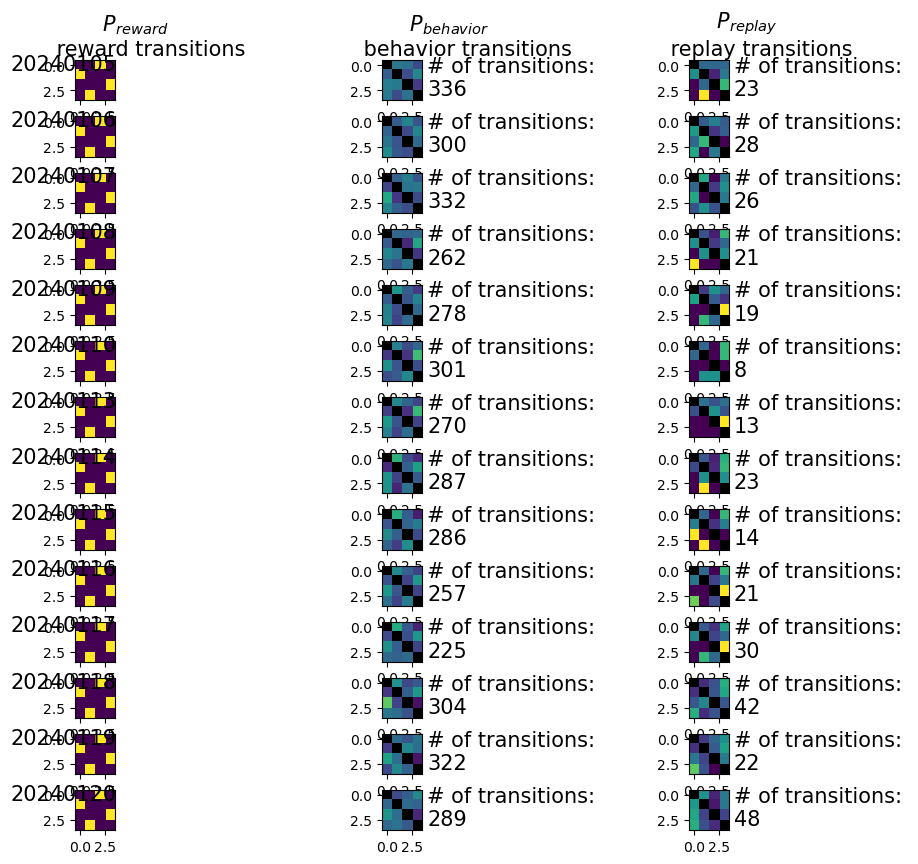

In [167]:
cmap = plt.cm.get_cmap().copy()
cmap.set_bad(color='black')

fig,axes=plt.subplots(len(files),3,figsize=(10,10),gridspec_kw={'hspace': 0.4, 'wspace': 0.9})

for f in range(len(files)):
    axes[f,0].text(-7,0.5,files[f][5:13],fontsize=15)
    axes[f,0].imshow(P_task[:,:,1],vmin=0, vmax=1)
    axes[f,1].imshow(P_behavior[:,:,f],vmin=0, vmax=1,cmap=cmap)
    axes[f,1].text(4,3,'# of transitions: \n'+str(int(P_behavior_count[f])),fontsize=15)
    axes[f,2].imshow(P_replay[:,:,f],vmin=0, vmax=1,cmap=cmap)
    axes[f,2].text(4,3,'# of transitions: \n'+str(int(P_replay_count[f])),fontsize=15)

axes[0,0].text(-3,-1,'        $P_{reward}$ \n reward transitions',fontsize=15); 
axes[0,1].text(-3,-1,'        $P_{behavior}$ \n behavior transitions',fontsize=15);
axes[0,2].text(-3,-1,'        $P_{replay}$ \n replay transitions',fontsize=15);

plt.savefig(os.path.join(datafolder,'pairwise matrix.pdf'),dpi=300)

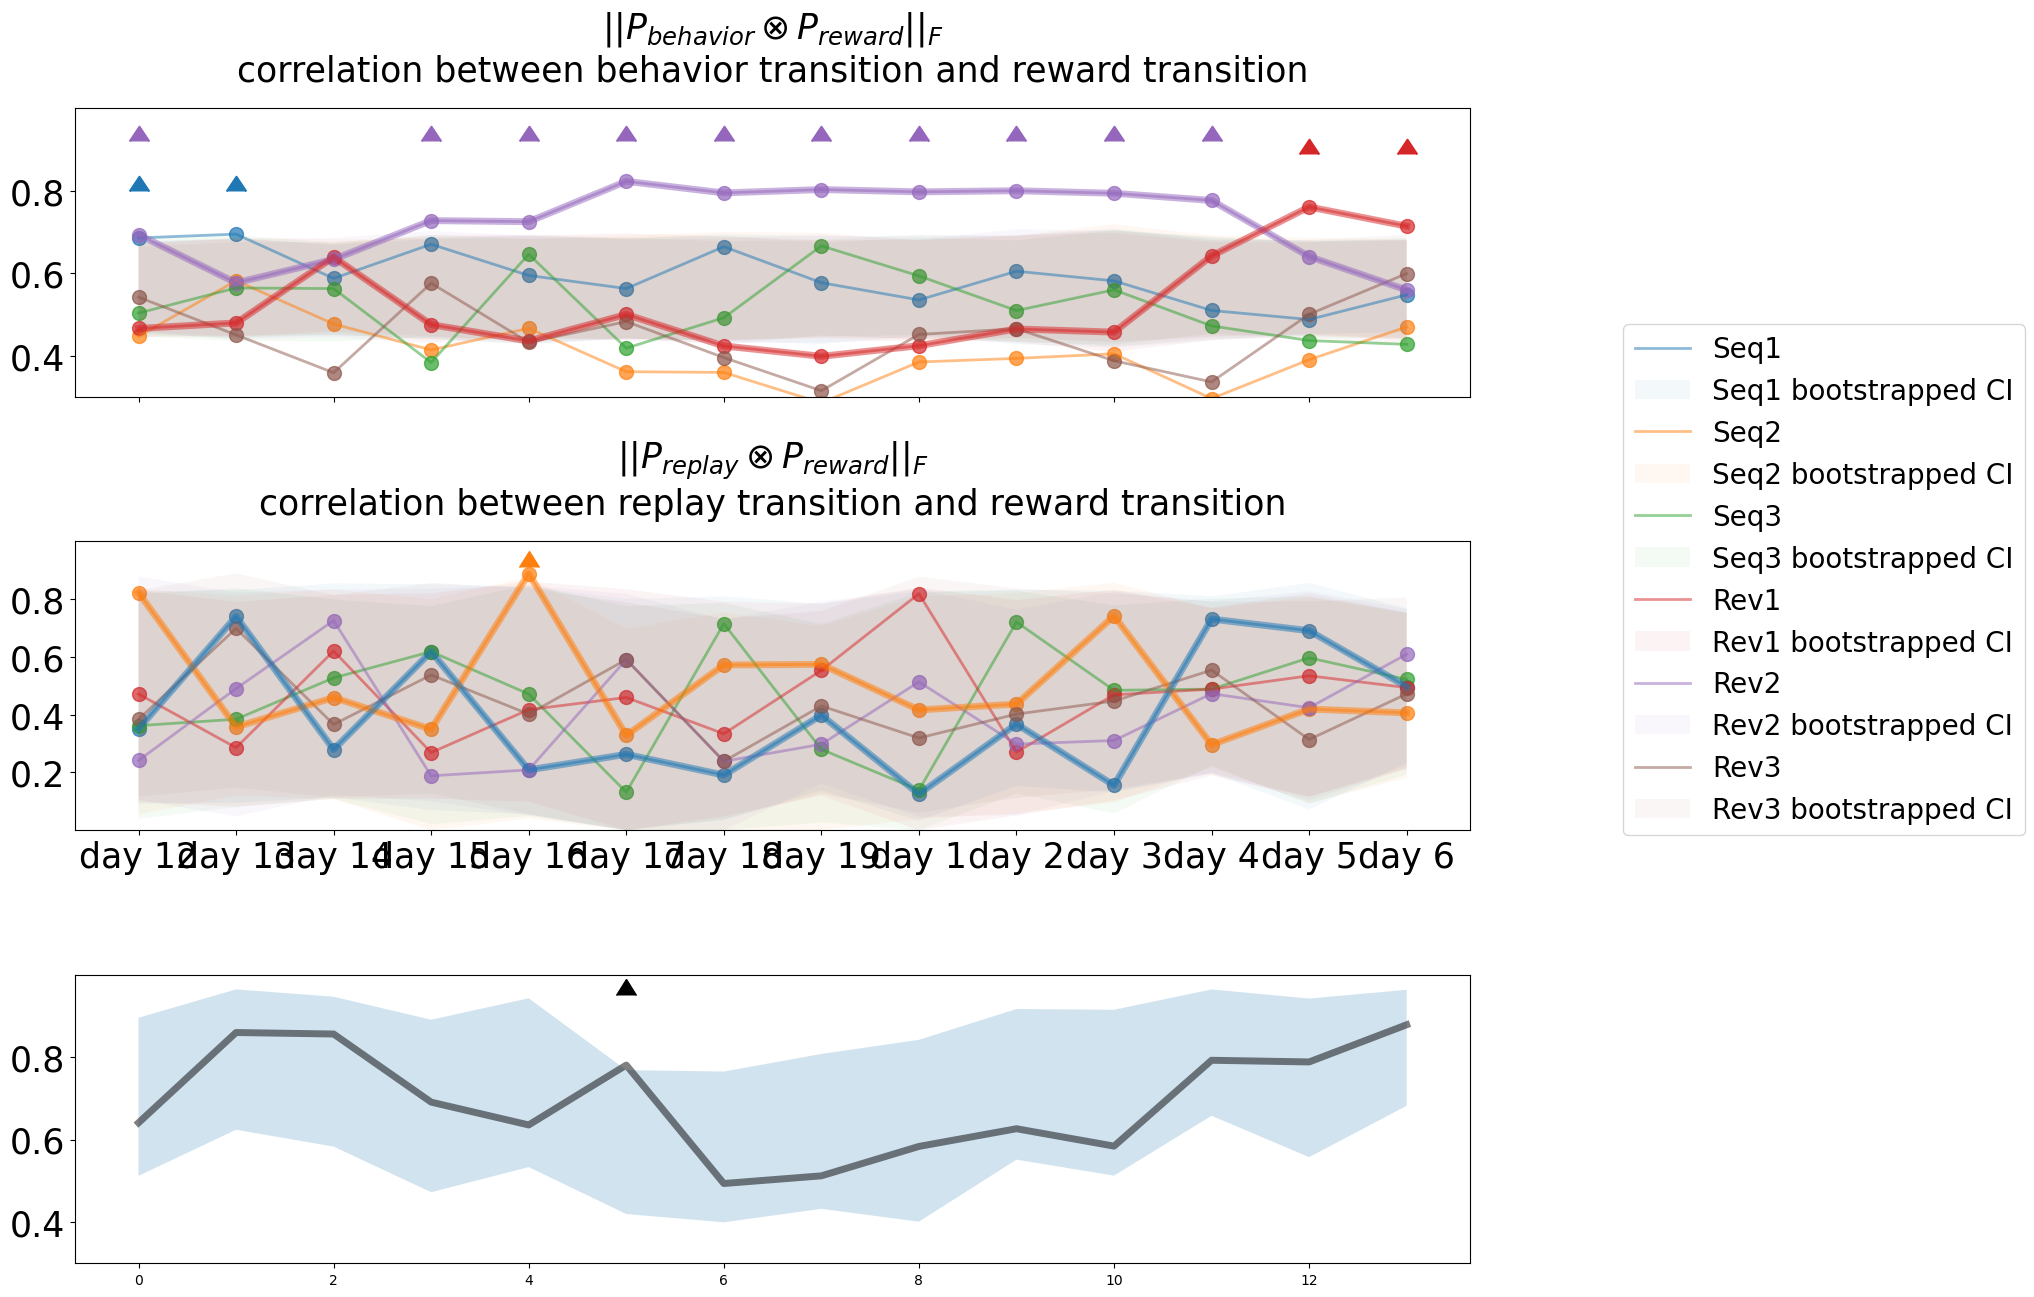

In [168]:
plot_significant_arrow=True

fig,axes=plt.subplots(3,1,figsize=(18,15),gridspec_kw={'hspace': 0.5, 'wspace': 0.9})
for seq_ind in range(6):
    axes[0].scatter(np.arange(len(files)),behavior_task[:,seq_ind],s=100,alpha=0.7)
    axes[0].plot(behavior_task[:,seq_ind],'-',linewidth=2,alpha=0.5,color='C'+str(seq_ind))
    axes[0].fill_between(np.arange(len(files)),
                         behavior_task_bootintvl[0,:,seq_ind],
                         behavior_task_bootintvl[1,:,seq_ind],
                         facecolor='C'+str(seq_ind), alpha=0.05,label=orders[seq_ind]+' bootstrapped CI')
    if plot_significant_arrow:
        significant_ind=np.argwhere(behavior_task[:,seq_ind]>behavior_task_bootintvl[1,:,seq_ind])
        axes[0].scatter(significant_ind,np.ones_like(significant_ind)*0.8+0.03*seq_ind,marker=10,s=200,color='C'+str(seq_ind))

        #significant_ind=np.argwhere(behavior_task[:,seq_ind]<behavior_task_bootintvl[0,:,seq_ind])
        #axes[0].scatter(significant_ind,np.ones_like(significant_ind)*0.8+0.04*seq_ind,marker=11,s=200,color='C'+str(seq_ind))    

# one thick line
if animal == 'Molly':
    axes[0].plot(behavior_task[:,1],linewidth=5,alpha=0.5,color='C'+str(1))
elif animal == 'Lewis':
    axes[0].plot(behavior_task[:,4],linewidth=5,alpha=0.5,color='C'+str(4))
    axes[0].plot(behavior_task[:,3],linewidth=5,alpha=0.5,color='C'+str(3))

for seq_ind in range(6):
    axes[1].scatter(np.arange(len(files)),replay_task[:,seq_ind],s=100,alpha=0.7)
    axes[1].plot(replay_task[:,seq_ind],'-',linewidth=2,alpha=0.5,color='C'+str(seq_ind),label=orders[seq_ind])
    axes[1].fill_between(np.arange(len(files)),
                         replay_task_bootintvl[0,:,seq_ind],
                         replay_task_bootintvl[1,:,seq_ind],
                         facecolor='C'+str(seq_ind), alpha=0.05,label=orders[seq_ind]+' bootstrapped CI')
    if plot_significant_arrow:
        significant_ind=np.argwhere(replay_task[:,seq_ind]>replay_task_bootintvl[1,:,seq_ind])
        axes[1].plot(significant_ind,np.ones_like(significant_ind)*0.9+0.01*seq_ind,marker=10,markersize=15,color='C'+str(seq_ind))

        significant_ind=np.argwhere(replay_task[:,seq_ind]<replay_task_bootintvl[0,:,seq_ind])
        axes[1].plot(significant_ind,np.ones_like(significant_ind)*0.9+0.01*seq_ind,marker=11,markersize=15,color='C'+str(seq_ind))

# one thick line
if animal == 'Molly':
    axes[1].plot(replay_task[:,4],linewidth=5,alpha=0.5,color='C'+str(4))
elif animal == 'Lewis':
    axes[1].plot(replay_task[:,1],linewidth=5,alpha=0.5,color='C'+str(1))
    axes[1].plot(replay_task[:,0],linewidth=5,alpha=0.5,color='C'+str(0))

axes[2].plot(behavior_replay,linewidth=5,alpha=0.5,color='k')
axes[2].fill_between(np.arange(len(files)),
                     behavior_replay_bootintvl[0,:],
                     behavior_replay_bootintvl[1,:],
                     facecolor='C0', alpha=0.2,label='bootstrapped CI')
if plot_significant_arrow:
    significant_ind=np.argwhere(behavior_replay>behavior_replay_bootintvl[1,:])
    axes[2].plot(significant_ind,np.ones_like(significant_ind)*0.9+0.01*seq_ind,marker=10,markersize=15,color='k')
    significant_ind=np.argwhere(behavior_replay<behavior_replay_bootintvl[0,:])
    axes[2].plot(significant_ind,np.ones_like(significant_ind)*0.9+0.01*seq_ind,marker=11,markersize=15,color='k')

# xticks
axes[0].set_xticklabels('',fontsize=16);
axes[1].set_xticklabels('',fontsize=16);
    
axes[1].set_xticks(np.arange(len(files)))#,fontsize=20);
axes[1].set_xticklabels(['day '+str(i) for i in days],fontsize=25);

# yticks
axes[0].set_yticks(np.arange(0.4,1,0.2))
axes[0].set_yticklabels([round(i,1) for i in np.arange(0.4,1,0.2)],fontsize=25)
axes[0].set_ylim([0.3,1])

axes[1].set_ylim([0,1])
axes[1].set_yticks(np.arange(0.2,1,0.2))
axes[1].set_yticklabels([round(i,1) for i in np.arange(0.2,1,0.2)],fontsize=25)


axes[2].set_yticks(np.arange(0,1,0.2))
axes[2].set_yticklabels([round(i,1) for i in np.arange(0,1,0.2)],fontsize=25)
axes[2].set_ylim([0.3,1])

# title
axes[0].set_title('$||P_{behavior} \otimes P_{reward}||_F$\ncorrelation between behavior transition and reward transition',
                  fontsize=25,pad=20)
axes[1].set_title('$||P_{replay} \otimes P_{reward}||_F$\ncorrelation between replay transition and reward transition',
                  fontsize=25,pad=20)

axes[1].legend(fontsize=20,bbox_to_anchor=(1.1, 1.8))

plt.savefig(os.path.join(datafolder,'pairwise correlation.pdf'),
            bbox_inches='tight', pad_inches=0.2,
            dpi=300)